# Klasifikasi Bunga menggunakan model AlexNet dan ResNet

## 1. Import Dataset and visualize some data

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import some visualization Libraries**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [ ]:
# Set Train and Test Directory Variables
TRAIN_DATA_DIR = "drive/MyDrive/PML/flower datasets/dataset/train/"
VALID_DATA_DIR = "drive/MyDrive/PML/flower datasets/dataset/valid/"

Class Directory:  94


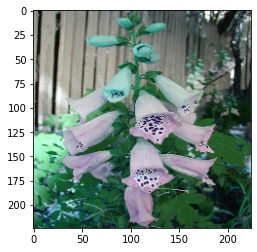

(224, 224, 3)


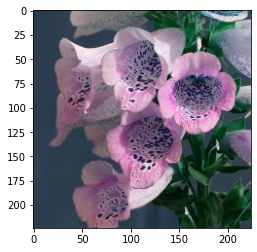

(224, 224, 3)


In [ ]:
#Visualiza Some Images of any Random Directory-cum-Class
FILE_DIR = str(np.random.randint(1,103))
print("Class Directory: ",FILE_DIR)
for file_name in os.listdir(os.path.join(TRAIN_DATA_DIR, FILE_DIR))[1:3]:
    img_array = cv2.imread(os.path.join(TRAIN_DATA_DIR, FILE_DIR, file_name))
    img_array = cv2.resize(img_array,(224, 224), interpolation = cv2.INTER_CUBIC)
    plt.imshow(img_array)
    plt.show()
    print(img_array.shape)

## 2. Data Preprocessing (Image Augmentation)

**Import PyTorch libraries**

In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
torch.__version__

'1.10.0+cu111'

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


**Make a Class Variable i.e a list of Target Categories (List of 102 species) **

In [ ]:
# I used os.listdir() to maintain the ordering 
classes = os.listdir(VALID_DATA_DIR)

In [ ]:
# Load and transform data using ImageFolder

data_transform2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = datasets.ImageFolder(TRAIN_DATA_DIR, transform=data_transform2)
test_data = datasets.ImageFolder(VALID_DATA_DIR, transform=data_transform2)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  6552
Num test images:  818


## 3. Make a DataLoader

In [ ]:
# define dataloader parameters
batch_size = 32
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

**Visualize Sample Images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

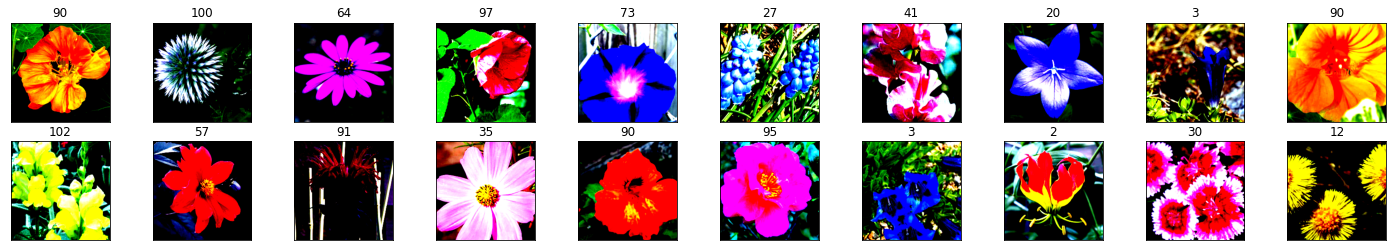

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

**Here plt.imshow() clips our data into [0,....,255] range to show the images. The Warning message is due to our Transform Function. We can Ignore it.**

## 4. Use a Pre-Trained Model

### 4.1 AlexNet

In [ ]:
# Load the pretrained model from pytorch
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We can see from above output that the last ,i.e, 6th Layer is a Fully-connected Layer with in_features=4096, out_features=1000

In [ ]:
print(model.classifier[6].in_features) 
print(model.classifier[6].out_features)

4096
1000


**Freeze Training for all 'Features Layers', Only Train Classifier Layers**

In [ ]:
# Freeze training for all "features" layers
for param in model.features.parameters():
    param.requires_grad = False

Let's Add our own Last Layer which will have 102 out_features for 102 species

In [ ]:
# AlexNet  
n_inputs = model.classifier[6].in_features

# add last linear layer (n_inputs -> 102 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

# AlexNet
model.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

# check to see that your last layer produces the expected number of outputs

#AlexNet
print(model.classifier[6].out_features)

102


### 4.2 ResNet

In [ ]:
model2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
print(model2)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Freeze training for all "features" layers
for _, param in model.named_parameters():
  param.requires_grad = False

In [ ]:
print(model2.fc.out_features)

1000


In [ ]:
# ResNet  
n_inputs = model2.fc.in_features

# add last linear layer (n_inputs -> 102 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

# ResNet
model2.fc = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    model2.cuda()

# check to see that your last layer produces the expected number of outputs

#ResNet
print(model2.fc.out_features)

102


# 5. Specify our Loss Function and Optimizer

In [ ]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01 or 0.001
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

# 6. Train our Model and Save necessary checkpoints

## 6.1 AlexNet

In [ ]:
# Define epochs (between 50-200)
epochs = 5
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# Some lists to keep track of loss and accuracy during each epoch
epoch_list = []
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
# Start epochs
for epoch in range(epochs):
    
    #adjust_learning_rate(optimizer, epoch)
    
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # Set the training mode ON -> Activate Dropout Layers
    model.train() # prepare model for training
    # Calculate Accuracy         
    correct = 0
    total = 0
    
    # Load Train Images with Labels(Targets)
    for data, target in train_loader:
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        if type(output) == tuple:
            output, _ = output
        
        # Calculate Training Accuracy 
        predicted = torch.max(output.data, 1)[1]        
        # Total number of labels
        total += len(target)
        # Total correct predictions
        correct += (predicted == target).sum()
        
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    
    # calculate average training loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    
    # Avg Accuracy
    accuracy = 100 * correct / float(total)
    
    # Put them in their list
    train_acc_list.append(accuracy)
    train_loss_list.append(train_loss)
    
    # Implement Validation like K-fold Cross-validation 
    
    # Set Evaluation Mode ON -> Turn Off Dropout
    model.eval() # Required for Evaluation/Test

    # Calculate Test/Validation Accuracy         
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Predict Output
            output = model(data)
            if type(output) == tuple:
                output, _ = output

            # Calculate Loss
            loss = criterion(output, target)
            val_loss += loss.item()*data.size(0)
            # Get predictions from the maximum value
            predicted = torch.max(output.data, 1)[1]

            # Total number of labels
            total += len(target)

            # Total correct predictions
            correct += (predicted == target).sum()
    
    # calculate average training loss and accuracy over an epoch
    val_loss = val_loss/len(test_loader.dataset)
    accuracy = 100 * correct/ float(total)
    
    # Put them in their list
    val_acc_list.append(accuracy)
    val_loss_list.append(val_loss)
    
    # Print the Epoch and Training Loss Details with Validation Accuracy   
    print('Epoch: {} \tTraining Loss: {:.4f}\t Val. acc: {:.2f}%'.format(
        epoch+1, 
        train_loss,
        accuracy
        ))
    # save model if validation loss has decreased
    if val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        val_loss))
        # Save Model State on Checkpoint
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = val_loss
    # Move to next epoch
    epoch_list.append(epoch + 1)

Epoch: 1 	Training Loss: 1.6317	 Val. acc: 80.44%
Validation loss decreased (inf --> 0.719429).  Saving model ...
Epoch: 2 	Training Loss: 0.5777	 Val. acc: 85.33%
Validation loss decreased (0.719429 --> 0.545043).  Saving model ...
Epoch: 3 	Training Loss: 0.3465	 Val. acc: 86.80%
Validation loss decreased (0.545043 --> 0.454964).  Saving model ...
Epoch: 4 	Training Loss: 0.2533	 Val. acc: 86.80%
Validation loss decreased (0.454964 --> 0.447740).  Saving model ...
Epoch: 5 	Training Loss: 0.1932	 Val. acc: 87.04%
Validation loss decreased (0.447740 --> 0.404795).  Saving model ...


## 6.2 ResNet

In [ ]:
# Define epochs (between 50-200)
epochs = 5
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# Some lists to keep track of loss and accuracy during each epoch
epoch_list2 = []
train_loss_list2 = []
val_loss_list2 = []
train_acc_list2 = []
val_acc_list2 = []
# Start epochs
for epoch in range(epochs):
    
    #adjust_learning_rate(optimizer, epoch)
    
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # Set the training mode ON -> Activate Dropout Layers
    model2.train() # prepare model for training
    # Calculate Accuracy         
    correct = 0
    total = 0
    
    # Load Train Images with Labels(Targets)
    for data, target in train_loader:
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        
        if type(output) == tuple:
            output, _ = output
        
        # Calculate Training Accuracy 
        predicted = torch.max(output.data, 1)[1]        
        # Total number of labels
        total += len(target)
        # Total correct predictions
        correct += (predicted == target).sum()
        
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    
    # calculate average training loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    
    # Avg Accuracy
    accuracy = 100 * correct / float(total)
    
    # Put them in their list
    train_acc_list2.append(accuracy)
    train_loss_list2.append(train_loss)
    
    # Implement Validation like K-fold Cross-validation 
    
    # Set Evaluation Mode ON -> Turn Off Dropout
    model2.eval() # Required for Evaluation/Test

    # Calculate Test/Validation Accuracy         
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Predict Output
            output = model2(data)
            if type(output) == tuple:
                output, _ = output

            # Calculate Loss
            loss = criterion(output, target)
            val_loss += loss.item()*data.size(0)
            # Get predictions from the maximum value
            predicted = torch.max(output.data, 1)[1]

            # Total number of labels
            total += len(target)

            # Total correct predictions
            correct += (predicted == target).sum()
    
    # calculate average training loss and accuracy over an epoch
    val_loss = val_loss/len(test_loader.dataset)
    accuracy = 100 * correct/ float(total)
    
    # Put them in their list
    val_acc_list2.append(accuracy)
    val_loss_list2.append(val_loss)
    
    # Print the Epoch and Training Loss Details with Validation Accuracy   
    print('Epoch: {} \tTraining Loss: {:.4f}\t Val. acc: {:.2f}%'.format(
        epoch+1, 
        train_loss,
        accuracy
        ))
    # save model if validation loss has decreased
    if val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        val_loss))
        # Save Model State on Checkpoint
        torch.save(model2.state_dict(), 'model2.pt')
        valid_loss_min = val_loss
    # Move to next epoch
    epoch_list2.append(epoch + 1)

Epoch: 1 	Training Loss: 3.1505	 Val. acc: 71.88%
Validation loss decreased (inf --> 1.731030).  Saving model ...
Epoch: 2 	Training Loss: 1.2595	 Val. acc: 89.24%
Validation loss decreased (1.731030 --> 0.784303).  Saving model ...
Epoch: 3 	Training Loss: 0.6201	 Val. acc: 94.38%
Validation loss decreased (0.784303 --> 0.462709).  Saving model ...
Epoch: 4 	Training Loss: 0.3652	 Val. acc: 95.72%
Validation loss decreased (0.462709 --> 0.326141).  Saving model ...
Epoch: 5 	Training Loss: 0.2413	 Val. acc: 96.21%
Validation loss decreased (0.326141 --> 0.260102).  Saving model ...


## Load Model State from Checkpoint

In [ ]:
model.load_state_dict(torch.load('model.pt'))
model2.load_state_dict(torch.load('model2.pt'))

<All keys matched successfully>

## Save the whole Model (Pickling)

In [ ]:
#Save/Pickle the Model
torch.save(model, 'classifier.pth')
torch.save(model2, 'classifier2.pth')

# 7. Visualize Model Training and Validation

##7.1 AlexNet

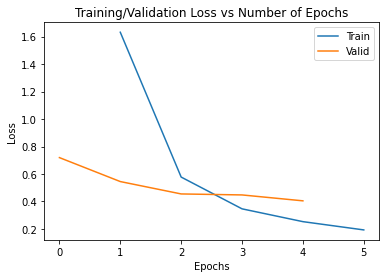

In [ ]:
# Training / Validation Loss
plt.plot(epoch_list,train_loss_list)
plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training/Validation Loss vs Number of Epochs")
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

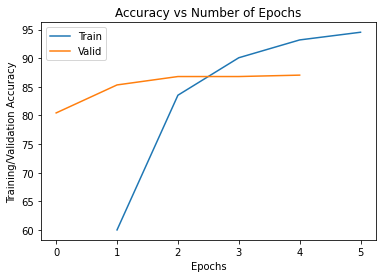

In [ ]:
# Train/Valid Accuracy
plt.plot(epoch_list,train_acc_list)
plt.plot(val_acc_list)
plt.xlabel("Epochs")
plt.ylabel("Training/Validation Accuracy")
plt.title("Accuracy vs Number of Epochs")
plt.legend(['Train', 'Valid'], loc='best')
plt.show()

From the above graphs we get some really impressive results

**Overall Accuracy
**

In [ ]:
val_acc = sum(val_acc_list[:]).item()/len(val_acc_list)
print("Validation Accuracy of model = {} %".format(val_acc))

Validation Accuracy of model = 85.2811767578125 %


##7.2 ResNet

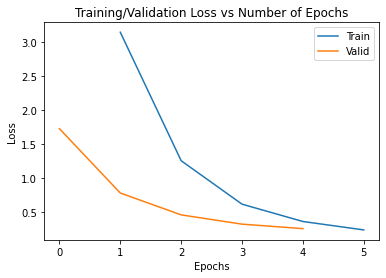

In [ ]:
# Training / Validation Loss
plt.plot(epoch_list2,train_loss_list2)
plt.plot(val_loss_list2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training/Validation Loss vs Number of Epochs")
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

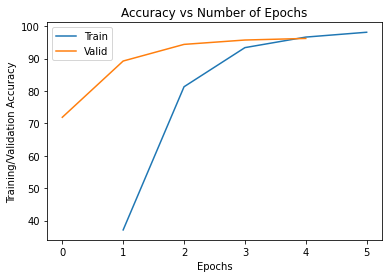

In [ ]:
# Train/Valid Accuracy
plt.plot(epoch_list2,train_acc_list2)
plt.plot(val_acc_list2)
plt.xlabel("Epochs")
plt.ylabel("Training/Validation Accuracy")
plt.title("Accuracy vs Number of Epochs")
plt.legend(['Train', 'Valid'], loc='best')
plt.show()

In [ ]:
val_acc = sum(val_acc_list2[:]).item()/len(val_acc_list2)
print("Validation Accuracy of model = {} %".format(val_acc))

Validation Accuracy of model = 89.48655395507812 %


# 8. Test our Model Performance 

##8.1 AlexNet

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

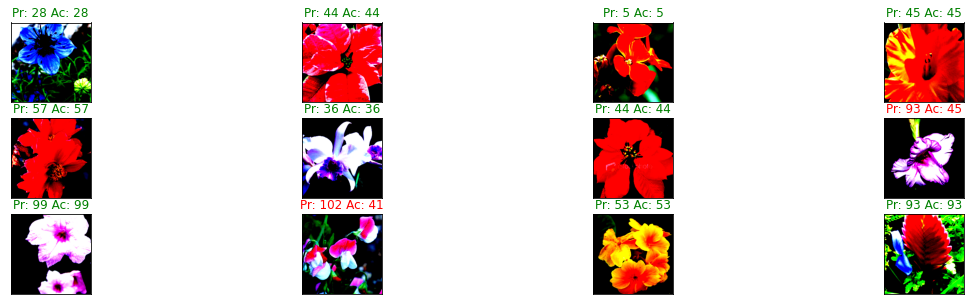

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
img = images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

model.eval() # Required for Evaluation/Test
# get sample outputs
output = model(images)
if type(output) == tuple:
            output, _ = output
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 5))
for idx in np.arange(12):
    ax = fig.add_subplot(3, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(img[idx], (1, 2, 0)))
    ax.set_title("Pr: {} Ac: {}".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

**We can see that the Correctly Classifies Results are Marked in "Green" and the misclassifies ones are "Red"**

##8.2 ResNet

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

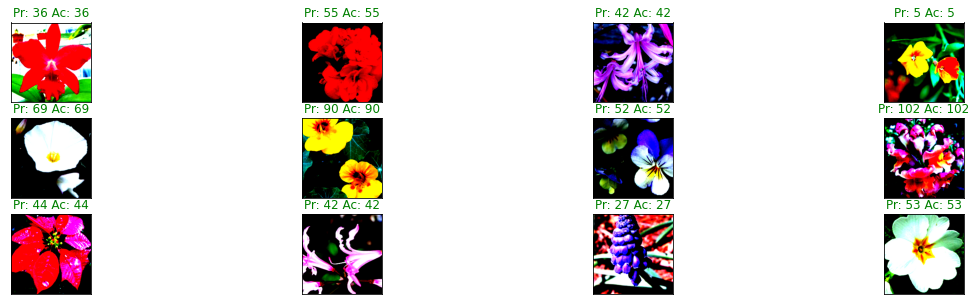

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
img = images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

model2.eval() # Required for Evaluation/Test
# get sample outputs
output = model2(images)
if type(output) == tuple:
            output, _ = output
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 5))
for idx in np.arange(12):
    ax = fig.add_subplot(3, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(img[idx], (1, 2, 0)))
    ax.set_title("Pr: {} Ac: {}".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))